In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, make_scorer, confusion_matrix, roc_curve, auc
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.proportion import proportion_confint

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

emails = pd.read_table("email.txt").drop('time',axis='columns')
emails = pd.get_dummies(emails,drop_first=True)
emails.head()

,spam,to_multiple,from,cc,sent_email,image,attach,dollar,inherit,viagra,...,num_char,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess,winner_yes,number_none,number_small
0,0,0,1,0,0,0,0,0,0,0,...,11.370,202,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,10.504,202,1,0,0,0,1,0,0,1
2,0,0,1,0,0,0,0,4,1,0,...,7.773,192,1,0,0,0,6,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,13.256,255,1,0,0,0,48,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,1.231,29,0,0,0,0,1,0,1,0


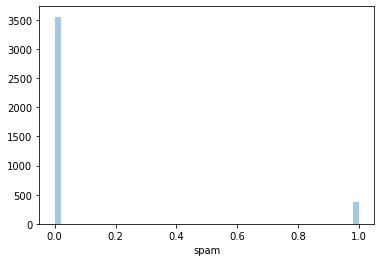

In [2]:
# Check out class distribution

sns.distplot(emails.spam, kde=False)

In [3]:
# How many positive class?

posrate = emails.spam.mean()
print(posrate)

0.09359857179290997


In [4]:
#Baseline accuracy?

baselineacc = 1 - posrate
print(baselineacc)

0.90640142820709


In [5]:
# Split data, train logistic regression

X = emails.drop('spam', axis='columns').astype('float').values
y = emails.spam.values

Xtrain, Xtest, ytrain, ytest = train_test_split(X,
                                                y, 
                                                test_size=0.5, 
                                                random_state=0)

emails_train, emails_test = train_test_split(emails, 
                                             test_size=0.5, 
                                             random_state=0)

LR=  LogisticRegression(solver='newton-cg', penalty = 'none',max_iter=10000)
lr = LR.fit(Xtrain,ytrain)

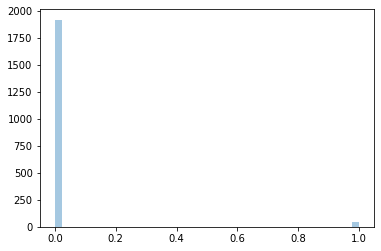

In [6]:
# Predict on test, check distribution of hard predicted values 
ytest_pred = lr.predict(Xtest)
sns.distplot(ytest_pred,kde=False)

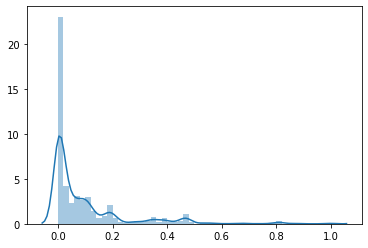

In [7]:
# Check distribution of predicted probabilities 
ytest_prob = lr.predict_proba(Xtest)
sns.distplot(ytest_prob[:,1])

In [8]:
# Calculate performance measures from scratch
# TP: true postives 
# TN: true negatives 
# FP: False positives 
# FN: False negatives
def compute_performance(yhat, y):
    # First, get tp, tn, fp, fn
    tp = sum(np.logical_and(yhat == 1, y == 1))
    tn = sum(np.logical_and(yhat == 0, y == 0))
    fp = sum(np.logical_and(yhat == 1, y == 0))
    fn = sum(np.logical_and(yhat == 0, y == 1))

    print(f"tp: {tp} tn: {tn} fp: {fp} fn: {fn}")
    
    # Accuracy
    trainacc = (tp + tn) / (tp + tn + fp + fn)
    
    # Precision
    # "Of the ones I labeled +, how many are actually +?"
    precision = tp / (tp + fp)
    
    # Recall
    # "Of all the + in the data, how many do I correctly label?"
    recall = tp / (tp + fn)    
    
    # Sensitivity
    # "Of all the + in the data, how many do I correctly label?"
    sensitivity = recall
    
    # Specificity
    # "Of all the - in the data, how many do I correctly label?"
    specificity = tn / (fp + tn)
    
    # Print results
    
    print("Acc:",round(trainacc,3),"Rec:",round(recall,3),"Prec:",round(precision,3),
          "Sens:",round(sensitivity,3),"Spec:",round(specificity,3))
    
    # Print CI for accuracy
    # We can use statsmodel's proportion_confint that uses a normal approximation 
    # to th binomial distribution 
    # proportion_confint(count, nobs, alpha=0.05, method='normal')
    print("CI for accuracy: ", proportion_confint(tp + tn, tp + tn + fp + fn ))

compute_performance(ytest_pred, ytest)

tp: 30 tn: 1763 fp: 12 fn: 156
Acc: 0.914 Rec: 0.161 Prec: 0.714 Sens: 0.161 Spec: 0.993
CI for accuracy:  (0.9019421285967516, 0.9267167189300204)


In [9]:
# Now let's experiment by adjusting the decision threshold 
compute_performance(ytest_prob[:,1]>0.3, ytest)

tp: 93 tn: 1662 fp: 113 fn: 93
Acc: 0.895 Rec: 0.5 Prec: 0.451 Sens: 0.5 Spec: 0.936
CI for accuracy:  (0.8813808046696991, 0.9085223059881284)


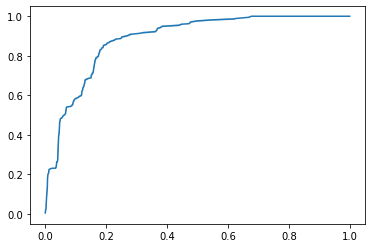

In [10]:
# ROC using sklearns ROC curve. 
fpr, tpr, _ = roc_curve(ytest, ytest_prob[:,1])
ax=sns.lineplot(fpr,tpr)

In [11]:
#AUROC
auc(fpr,tpr)

0.8857276995305164

In [12]:
# Confidence interval for AUROC

def auroc_ci(data, model, numboot=1000):
    b_auroc = np.zeros(numboot)
    for i in range(numboot):
        df_bootstrapped = data.sample(data.shape[0], replace = True)
        y = df_bootstrapped.spam
        yhat = model.predict_proba(df_bootstrapped.drop('spam',axis='columns'))[:,1]
        fpr, tpr, _ = roc_curve(y, yhat)
        b_auroc[i] = auc(fpr,tpr)
    return np.quantile(b_auroc,(0.025,0.975))
    
print(auroc_ci(emails_test, lr))

[0.86310599 0.90556985]
